Let's say we have the following problem statement:

![Problem1](problem1.jpg)
![Problem2](problem2.jpg)
![Problem3](problem3.jpg)
![Problem4](problem4.jpg)
![Problem5](problem5.jpg)
![Problem6](problem6.jpg)

I thought we would try something exotic as the goal here is not optimization.  After setting up the data, preprocessing the data, and using pretrained word embeddings, Let's train a recurrent neural network (RNN)/convolution neural network (CNN) with attention hybrid model to classify the text. The theory is that the CNN reduces the ngrams down to smaller elements or a single element while the RNN captures the flow of the ideas in the text. Attention with context has been shown to be a powerful tool for handling long distance relationships, which are of course very common in text data. We can use Keras to implement the network.

In [1]:
#google colab. Use this cell if you need gensim
!pip install gensim

    100% |████████████████████████████████| 23.6MB 2.0MB/s 
    100% |████████████████████████████████| 1.4MB 14.6MB/s 
    100% |████████████████████████████████| 133kB 28.3MB/s 
    100% |████████████████████████████████| 4.7MB 1.1MB/s 
    100% |████████████████████████████████| 61kB 23.1MB/s 
    100% |████████████████████████████████| 552kB 25.8MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [ ]:
import numpy as np
import glob
import pandas as pd
import codecs
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [3]:
#google colab
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv


In [0]:
train_path = r"./20news-bydate/20news-bydate-train/*/*"
train_files = glob.glob(train_path)

def data_setup(files):
    categories = []; doc_ids = []; docs = [];
    for file in files:
        
        with codecs.open(file, 'rb') as f:
            docs.append(f.read())
        divide = file.split(r"/")
        
        categories.append(divide[3]); doc_ids.append(divide[4])
    
    dic = {'Doc ID': doc_ids, 'Category': categories, 'Document': docs}
    data = pd.DataFrame(dic)
                   
            
    
    return categories, doc_ids, docs, data

train_labs, train_doc_ids, train_docs, train_data = data_setup(train_files)

In [0]:
len(train_labs), len(train_doc_ids), len(train_docs), len(train_data)

(0, 0, 0, 0)

In [0]:
test_path = "./20news-bydate/20news-bydate-test/*/*"
test_files = glob.glob(test_path)
test_labs, test_doc_ids, test_docs, test_data = data_setup(test_files)

In [0]:
len(test_labs), len(test_doc_ids), len(test_docs), len(test_data)

(7532, 7532, 7532, 7532)

In [0]:
train_data.head()

,Category,Doc ID,Document
0,talk.politics.mideast,10267,b'From: sera@zuma.UUCP (Serdar Argic)\nSubject...
1,talk.politics.mideast,10239,b'From: sera@zuma.UUCP (Serdar Argic)\nSubject...
2,talk.politics.mideast,10423,b'From: ehrlich@bimacs.BITNET (Gideon Ehrlich)...
3,talk.politics.mideast,10352,"b""Nntp-Posting-Host: sinober.ifi.uio.no\nFrom:..."
4,talk.politics.mideast,10190,b'From: sera@zuma.UUCP (Serdar Argic)\nSubject...


In [0]:
train_data.tail()

,Category,Doc ID,Document
11309,talk.politics.guns,9390,b'From: jmd@cube.handheld.com (Jim De Arras)\n...
11310,talk.politics.guns,9734,"b""From: feustel@netcom.com (David Feustel)\nSu..."
11311,talk.politics.guns,9668,b'From: bjones@convex.com (Brad Jones)\nSubjec...
11312,talk.politics.guns,9670,"b""From: betz@gozer.idbsu.edu (Andrew Betz)\nSu..."
11313,talk.politics.guns,9546,"b""From: diederic@spot.Colorado.EDU (Andrew Die..."


In [0]:
test_data.head()

,Category,Doc ID,Document
0,talk.politics.mideast,18240,b'From: harry@hershele.alf.dec.com (Harry Katz...
1,talk.politics.mideast,17987,"b""From: murthy@ssdsun.asl.dl.nec.com (Vasudev ..."
2,talk.politics.mideast,18270,b'From: tclock@orion.oac.uci.edu (Tim Clock)\n...
3,talk.politics.mideast,17975,b'From: aap@wam.umd.edu (Alberto Adolfo Pinkas...
4,talk.politics.mideast,17995,"b""From: oaf@zurich.ai.mit.edu (Oded Feingold)\..."


In [0]:
test_data.tail()

,Category,Doc ID,Document
7527,talk.politics.guns,17861,b'From: mlh@austin.ibm.com (Sewer Snake)\nSubj...
7528,talk.politics.guns,17700,b'From: cdt@sw.stratus.com (C. D. Tavares)\nSu...
7529,talk.politics.guns,17592,b'From: 0005111312@mcimail.com (Peter Nesbitt)...
7530,talk.politics.guns,17867,b'From: robert@isgtec.com (Robert Osborne)\nSu...
7531,talk.politics.guns,17699,"b""From: cdt@sw.stratus.com (C. D. Tavares)\nSu..."


Corpus examination

In [0]:
print(train_data.shape, test_data.shape)
print(train_data.isnull().sum())
print(test_data.isnull().sum())

(11314, 3) (7532, 3)
Category    0
Doc ID      0
Document    0
dtype: int64
Category    0
Doc ID      0
Document    0
dtype: int64


Snowball stemmer from nltk

Data alternatively available here:

In [0]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

Convert from byte to string and stem for preprocessing

In [0]:
def strAndStem(sentence):
    tokens = sentence.split()
    true_tokens = [stemmer.stem((str(token))) for token in tokens]
    return ' '.join(true_tokens)

In [0]:
train_data["stemmed_document"] = train_data["Document"].apply(strAndStem)
test_data["stemmed_document"] = test_data["Document"].apply(strAndStem)

For model training in google colab. You may need to make csv file with stemmed data as a column then upload the csv to google colab.

In [0]:
#google colab
import io
test_data = pd.read_csv(io.StringIO(uploaded['test_data.csv'].decode('utf-8')))
train_data = pd.read_csv(io.StringIO(uploaded['train_data.csv'].decode('utf-8')))

Getting data labels

In [0]:
categories = train_data['Category'].unique()
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
    
train_labels = train_data['Category'].apply(lambda x: cate_dic[x])

test_categories = test_data['Category'].unique()
cate_dic = {}
for i, cate in enumerate(test_categories):
    cate_dic[cate] = i
    
test_labels = test_data['Category'].apply(lambda x: cate_dic[x])

In [6]:
test_categories

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

Preprocess data for neural network using Keras

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
train_text = train_data['stemmed_document']
test_text = test_data['stemmed_document']

In [0]:
WORD_NUM = 20000 #arbitrary choice, but commonly used vocab size when using word embeddings

In [10]:
tokenizer = Tokenizer(num_words = WORD_NUM,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower = True)
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)
word_index = tokenizer.word_index
print("The vocab is {0}.".format(len(word_index)))

The vocab is 123471.


In [0]:
MAX_SEQUENCE_LENGTH = 1000 #abritrary choice

Set up train and test matrixes. Did not have enough time for dev/validation set.

In [12]:
X_train = pad_sequences(train_seq, maxlen= MAX_SEQUENCE_LENGTH)
y_train = to_categorical(np.asarray(train_labels[train_data.index]))
X_test = pad_sequences(test_seq, maxlen = MAX_SEQUENCE_LENGTH)
y_test = to_categorical(np.asarray(test_labels[test_data.index]))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11314, 1000) (11314, 20)
(7532, 1000) (7532, 20)


Use Google's pretrained word vectors. I think I got them here originally:
https://code.google.com/archive/p/word2vec/

In [14]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

FileNotFoundError: ignored

Altneratively, use word2vec to create own word vectors. This implementation uses custom word vectors trained with default settings

In [13]:
wvmodel = Word2Vec(size=300,
                    min_count=5,
                    workers=3)


wvmodel.build_vocab(train_text)


wvmodel.train(train_text,
              total_examples = wvmodel.corpus_count,
              epochs = wvmodel.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # This is added back by InteractiveShellApp.init_path()


(28557611, 133386605)

In [14]:
EMBEDDING_DIM = 300 # recommended size in https://arxiv.org/abs/1301.3781
vocab = min((len(word_index), WORD_NUM))
embed_matrix = np.zeros((vocab, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= WORD_NUM:
        continue
    try:
        word_vec = wvmodel[word]
        embed_matrix[i] = word_vec
    except KeyError:
        embed_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
embed_matrix.shape

(20000, 300)

**Neural network architecture:**


Embedding layer > long short term memory (LSTM) > CNN1 > CNN2 Attention > Fully-connected > Softmax


In [16]:
!pip install keras_utilities

  Running setup.py bdist_wheel for keras-utilities ... - done
  Stored in directory: /root/.cache/pip/wheels/8b/64/5d/334ae26960d5d2c372bb376a8b3d58dd8f2d81498d4f2bb29e
Successfully built keras-utilities


In [0]:
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Dense, Activation, Multiply, Add, LSTM, LeakyReLU, Flatten
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from kutilities.layers import AttentionWithContext
from keras.callbacks import EarlyStopping, ModelCheckpoint

Hyperparameters

In [0]:
LAB_NUMBER = y_train.shape[1] # number of labels, 20 in this case
WREG = 0.001 # embedding regularization
CREG = 0.00001 # CNN regularization
RREG = 0.00001 # LSTM regularization
DREG = 0.00001 # Fully connected regularization
WDROP_RATE = 0.70 # embedding dropout
CDROP_RATE = 0.33 # CNN dropout
RDROP_RATE = 0.50 # LSTM dropout
DDROP_RATE = 0.25 # fully connected dropout
CHIDDEN_SIZE = 32 # CNN size
RHIDDEN_SIZE = 64 # LSTM size 
DHIDDEN_SIZE = 128 # fully connected size
SEQ_LEN = MAX_SEQUENCE_LENGTH
EPOCH = 500
BATCH_SIZE = 128

Embedding layer from word2vec custome embeddings

In [0]:
embed = Embedding(vocab,
                  EMBEDDING_DIM,
                  weights=[embed_matrix],
                  trainable=True, 
                  embeddings_regularizer=l2(WREG))

Input

In [0]:
inputs = Input(shape=(SEQ_LEN,), dtype='int32')
embed_sequence = embed(inputs)

embed_sequence = Dropout(WDROP_RATE)(embed_sequence)

RNN

In [0]:
lstm1 = LSTM(RHIDDEN_SIZE, 
             kernel_regularizer=l2(RREG), 
             return_sequences = True)(embed_sequence)
lstm1 = Dropout(RDROP_RATE)(lstm1)

CNNs and Attention with Context

In [0]:
cnn1 = Conv1D(filters = CHIDDEN_SIZE, 
              kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1)(lstm1)
cnn1 = Activation('relu')(cnn1)
cnn1 = MaxPooling1D(5)(cnn1)
cnn1 = Dropout(CDROP_RATE)(cnn1)

cnn2 = Conv1D(filters = CHIDDEN_SIZE, 
              kernel_regularizer=l2(CREG), 
              kernel_size=(5), 
             padding="valid", 
             strides=1)(cnn1)
cnn2 = Activation('relu')(cnn2)
cnn2 = MaxPooling1D(5)(cnn2)
cnn2 = Dropout(CDROP_RATE)(cnn2)
cnn2 = AttentionWithContext()(cnn2)

Fully-connected with leaky relu and softmax

In [0]:
out = Dense(DHIDDEN_SIZE,
            kernel_regularizer=l2(DREG))(cnn2)
out = LeakyReLU()(out)
out = Dropout(DDROP_RATE)(out)


prediction = Dense(LAB_NUMBER, 
                   activation = 'softmax')(out)

In [0]:
model = Model(inputs, prediction)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 64)          93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          6176      
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 32)          0         
__________

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

Early stopping and storing best model

In [0]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [28]:
history = model.fit(X_train, y_train, 
          validation_data = (X_test, y_test),
          epochs = EPOCH,
          verbose = 1,
          callbacks = callbacks,
          batch_size = BATCH_SIZE)

Train on 11314 samples, validate on 7532 samples
Epoch 1/500
11314/11314 [==============================] - 224s 20ms/step - loss: 1312.4191 - acc: 0.0616 - val_loss: 1131.9651 - val_acc: 0.0743
Epoch 2/500
11314/11314 [==============================] - 219s 19ms/step - loss: 990.1933 - acc: 0.0774 - val_loss: 857.1687 - val_acc: 0.0978
Epoch 3/500
11314/11314 [==============================] - 219s 19ms/step - loss: 751.3334 - acc: 0.0959 - val_loss: 651.6039 - val_acc: 0.1147
Epoch 4/500
11314/11314 [==============================] - 219s 19ms/step - loss: 571.8677 - acc: 0.1121 - val_loss: 496.5335 - val_acc: 0.1223
Epoch 5/500
11314/11314 [==============================] - 219s 19ms/step - loss: 436.0929 - acc: 0.1253 - val_loss: 378.8788 - val_acc: 0.1257
Epoch 6/500
11314/11314 [==============================] - 219s 19ms/step - loss: 332.8551 - acc: 0.1508 - val_loss: 289.2958 - val_acc: 0.1714
Epoch 7/500
11314/11314 [==============================] - 220s 19ms/step - loss: 254

Accuracy and loss analysis

In [29]:
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

7532/7532 [==============================] - 122s 16ms/step
Evaluation result on Test Data : Cost = 1.675183529747463, accuracy = 75.29208709506108


In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Accuracy Curves')

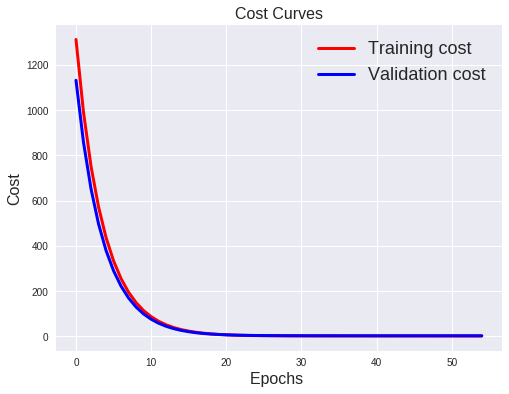

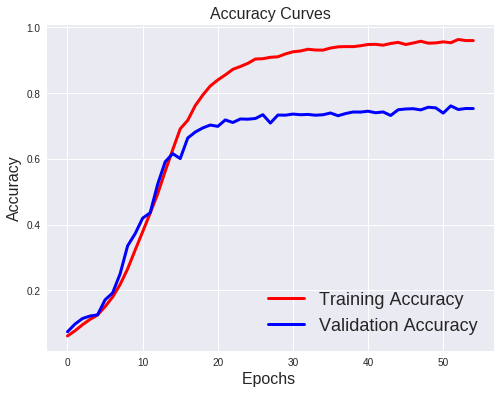

In [31]:
#Plot cost
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training cost', 'Validation cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Cost Curves',fontsize=16)
 
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Model is clearly overfit

Error analysis:

Precision, recall, F1, support, and confusion matrix 

In [0]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

In [0]:
y_probs = model.predict(X_test)
y_hat = y_probs.argmax(axis=-1)

In [0]:
precision, recall, fscore, support = score(test_labels[test_data.index], y_hat)

In [35]:
test_categories

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [0]:
cm = confusion_matrix(test_labels[test_data.index], y_hat)

In [37]:
print(cm)

[[201   0   0   3   0   4   0   0   0   0   0   1   0   4   2  35   7   6
    4  52]
 [  0 282  11  12   3   8   7   4   0   1   0   2  35   9  11   2   1   1
    0   0]
 [  8  34 208  76  10  17  15   0   0   1   1   0   3   1   1  18   0   0
    0   1]
 [  2  12  18 273  26   2  28   4   0   0   2   0  16   3   0   3   0   0
    0   3]
 [  0   4   3  31 293   0  19   3   0   1   0   0  22   6   1   0   1   0
    0   1]
 [  0  67  21  14   2 270   2   0   0   0   1   1   8   4   4   0   1   0
    0   0]
 [  0   5   4  16  16   0 308  13   3   2   1   0  15   5   0   0   0   0
    2   0]
 [  0   0   0   1   1   1  10 341   8   3   0   0  13  15   0   1   1   0
    1   0]
 [  1   0   0   0   0   1   2  12 347   5   0   0  13  13   1   1   0   0
    2   0]
 [  0   0   2   0   0   0   6   7   1 352   6   0   0   7   0   6   0   0
   10   0]
 [  2   1   0   0   0   1   4   0   0  66 313   0   0   1   3   7   0   0
    1   0]
 [  3   2   0   0   0   1   1   4   1   4   1 335   6   2  18   0

Text(0.5,1,'CNN & RNN Hybrid Network Text Classification Confusion Matrix')

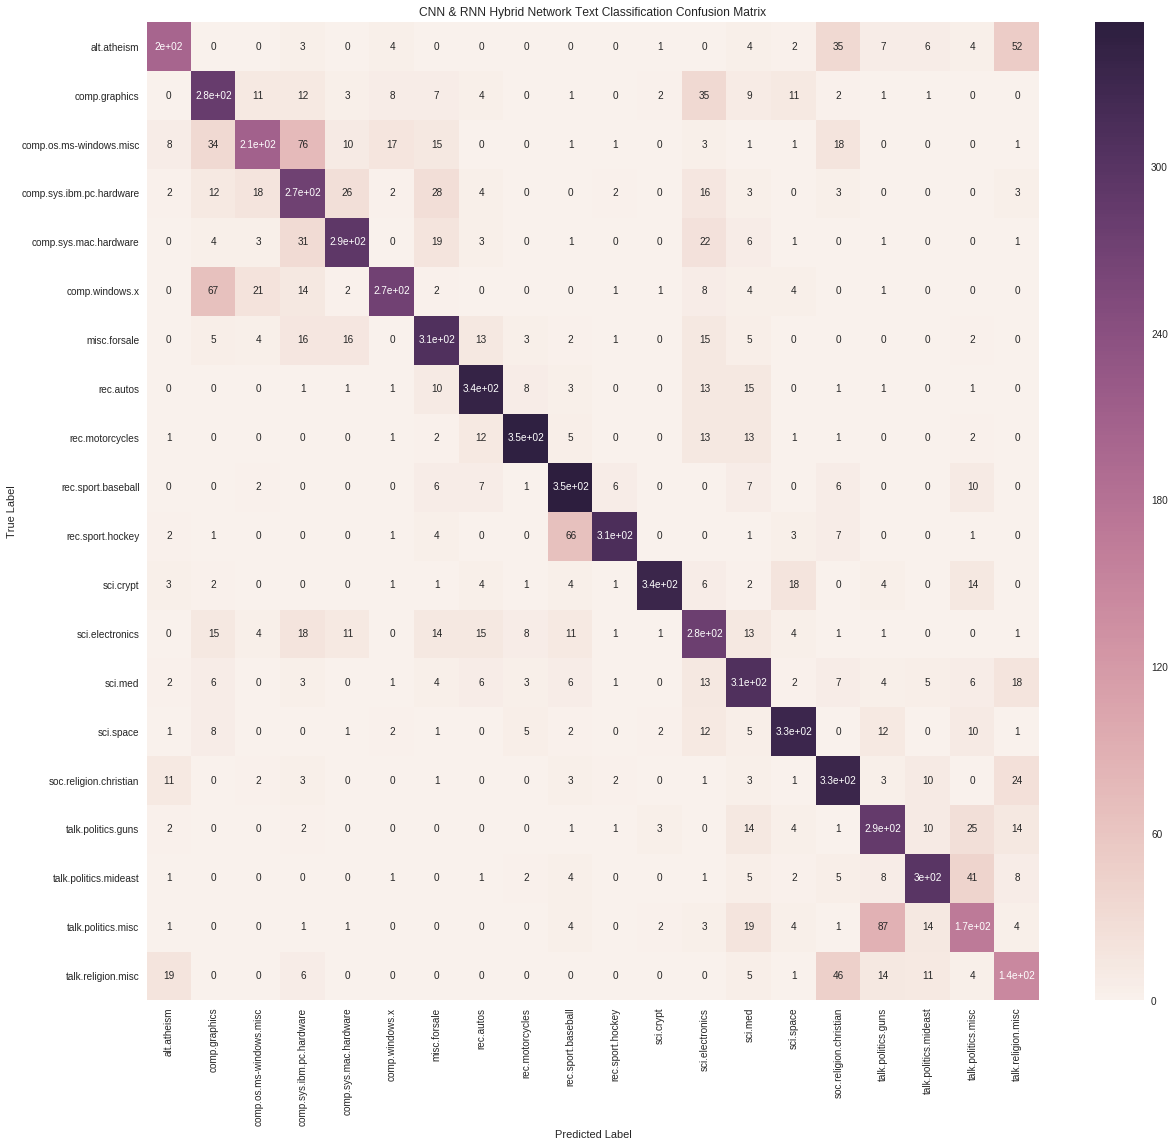

In [38]:
cm = pd.DataFrame(cm, index = [i for i in test_categories], columns = [i for i in test_categories])
plt.figure(figsize = (20, 18))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN & RNN Hybrid Network Text Classification Confusion Matrix')

In [0]:
analysis = pd.DataFrame()
analysis['Precision'] = precision; analysis['Recall'] = recall; analysis['F1 Score'] = fscore; analysis['Support'] = support
analysis.insert(0, 'Category', ['{0}'.format(i) for i in test_categories])

In [40]:
analysis

,Category,Precision,Recall,F1 Score,Support
0,alt.atheism,0.791339,0.630094,0.701571,319
1,comp.graphics,0.646789,0.724936,0.683636,389
2,comp.os.ms-windows.misc,0.761905,0.527919,0.623688,394
3,comp.sys.ibm.pc.hardware,0.594771,0.696429,0.641598,392
4,comp.sys.mac.hardware,0.804945,0.761039,0.782377,385
5,comp.windows.x,0.873786,0.683544,0.767045,395
6,misc.forsale,0.729858,0.789744,0.758621,390
7,rec.autos,0.831707,0.861111,0.846154,396
8,rec.motorcycles,0.917989,0.871859,0.894330,398
9,rec.sport.baseball,0.755365,0.886650,0.815759,397


In [41]:
analysis.mean()

Precision      0.756806
Recall         0.746342
F1 Score       0.747349
Support      376.600000
dtype: float64

Set up dataframe with model probabilities for each label.

In [0]:
probabilities = [(i*100) for i in model.predict(X_test)]

In [0]:
submit = pd.DataFrame(probabilities, columns= ['{0}'.format(i) for i in test_categories])
submit.insert(0, 'doc_id', test_data['Doc ID'])

In [44]:
submit.head()

,doc_id,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,...,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
0,11315,2.354714,2.548521e-04,0.136742,0.518946,3.102285e-04,0.001188,1.434288e-01,3.203167e-03,2.852013e-05,...,2.353316e-01,0.001623,5.281042e-05,3.764123e-03,1.476450e-06,94.734444,0.000959,6.950671e-02,2.802717e-03,1.766981
1,11316,99.992607,9.056671e-12,0.000002,0.000031,4.791456e-16,0.000057,1.676093e-12,7.642510e-17,3.649624e-18,...,1.949516e-07,0.000033,1.051223e-16,5.127388e-13,1.941702e-13,0.000378,0.000003,4.611753e-07,4.341922e-10,0.006892
2,11317,99.925133,3.845608e-10,0.000011,0.000374,3.013696e-13,0.000197,1.241758e-10,7.106000e-14,1.783893e-15,...,9.796902e-07,0.000142,5.632685e-14,3.026650e-10,2.192548e-11,0.003611,0.000066,1.514043e-05,2.613706e-08,0.070449
3,11318,97.571465,3.782096e-07,0.011874,0.051791,1.902912e-09,0.001231,4.571531e-06,1.755240e-09,2.098062e-11,...,1.611795e-03,0.000566,3.333731e-10,1.354670e-07,7.985180e-10,1.896025,0.000076,2.374918e-04,1.006431e-06,0.465114
4,11319,21.144979,1.195484e-01,0.044171,0.071625,3.278284e-04,7.952794,5.952135e-04,6.850400e-04,1.492617e-02,...,3.276293e-02,24.313086,1.242386e-02,1.085548e-01,7.008487e+00,0.016363,36.649014,6.597234e-02,1.597636e+00,0.845540


In [45]:
submit.tail()

,doc_id,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,...,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
7527,18842,3.438458,2.032471e-09,8.495425e-08,0.016708,6.937497e-07,5.334620e-06,1.273461e-08,4.048496e-08,5.119310e-12,...,4.449794e-09,4.771891e-06,7.489978e-09,0.004088,6.168743e-09,0.085753,0.132536,0.107608,1.805049e-05,96.214813
7528,18843,0.067796,2.052532e-12,8.444357e-10,0.005366,1.099286e-07,6.185593e-10,8.167979e-09,4.192185e-08,8.893990e-15,...,3.028725e-11,3.813073e-10,7.705055e-11,0.001054,3.378317e-14,1.994765,0.000062,0.011504,6.109397e-08,97.919449
7529,18844,1.558952,1.091283e-02,1.829315e-01,0.139604,1.277898e-02,1.383526e-02,1.433770e+00,4.778287e-01,9.446079e-02,...,6.578710e+00,8.549726e-02,9.955624e-03,0.704377,4.155052e-03,59.340645,0.090040,3.669384,2.120571e+00,2.174082
7530,18845,80.771736,4.977025e-04,2.676559e-02,2.634928,1.218719e-04,8.798768e-02,2.824056e-04,1.544070e-05,2.425346e-07,...,1.132728e-03,2.052927e-02,2.471665e-05,0.004359,2.849137e-05,1.293925,0.135047,0.038468,6.935531e-04,14.983442
7531,18846,0.273141,5.975414e-12,2.595806e-10,0.012923,5.867243e-08,2.947557e-08,2.871913e-11,1.741412e-10,2.547742e-16,...,1.885612e-13,4.697513e-09,7.133137e-11,0.000556,3.518840e-12,0.002734,0.006987,0.000973,1.088457e-08,99.702682


In [0]:
submit.to_csv("we_are_done.csv")

**Potential improvements to current approach**

Sentence level embeddings instead of word level (sent2vec)

Hyperparameter tuning for better regularization: Dropout precentage, l2 regularization parameter

More comprehensive preprocessing. The vocab size was 126k which is much too large, indicating the stemmer wasn't stemming very well.

Use text frequency inverse document frequency (tfidf) to reduce vocab size.

Use word-piece or character-level instead of word level like https://arxiv.org/abs/1609.03777 for example.

** Alternative approaches **
CNN > RNN (with attention) > softmax:
https://github.com/LuketheDukeBates/CNN-RNN-Text-Classifier/blob/master/Text%20classification%20CNN%20%26%20RNN%20hybrid%20network%20with%20word%20embeddings.ipynb

Pure CNNs > softmax

Pure RNNs > softmax

bag of words count vectorizer (BoW) > tfidf >  single value decomposition (SVD) > support vector machine (SVM) (no neural network)

**Production**

Once the model has been optimized, pickle the model to store it and retrieve it in its original state.

If necessary, use JSON to store data

Use  Flask, Django, Falcon, Hug, etc for web-based application

Create API

Deploy API perhaps using virtual machine